In [2]:
from pandas import DataFrame
import re
import json
import pandas as pd
ACTION_INPUT_RE = re.compile(r'action\s*input\s*:(\{.*?\})', flags=re.IGNORECASE | re.DOTALL)

def updaterows(df: DataFrame):
    def extract_answer_goal(conv):
        try:
            # Expect a list of dicts with a "value" field
            if not isinstance(conv, (list, tuple)) or not conv:
                return pd.Series({"teacher_ground_truth": "", "teacher_goal_type": "", "has_finish": False})

            last_val = (conv[-1] or {}).get("value", "")
            if not isinstance(last_val, str):
                last_val = str(last_val)

            # has_finish (case-insensitive)
            has_finish = "action:finish" in last_val.lower()

            # Extract JSON after "Action Input:"
            m = ACTION_INPUT_RE.search(last_val)
            if not m:
                return pd.Series({"teacher_ground_truth": "", "teacher_goal_type": "", "has_finish": has_finish})

            data = json.loads(m.group(1))
            return pd.Series({
                "teacher_ground_truth": data.get("answer", "") or "",  #predicted goal
                "teacher_goal_type": data.get("goal_type", "") or "", #predicted goal
                "has_finish": has_finish
            })
        except Exception:
            # Be resilient to bad rows
            return pd.Series({"teacher_ground_truth": "", "teacher_goal_type": "", "has_finish": False})

    # Vectorized-ish extraction into three columns
    df[["teacher_ground_truth", "teacher_goal_type", "has_finish"]] = df["conversation"].apply(extract_answer_goal)

    df["conversation_count"] = df["conversation"].apply(len)
    df["steps"] = df["conversation"].apply(len) // 2
    # List of word counts per message
    df["word_count"] = df["conversation"].apply(
        lambda conv: ",".join(str(len(c.get("value", "").split())) for c in conv)
    )

    df["ERROR"] = df["conversation"].apply(
    lambda conv: ",".join(
        str(i) for i, c in enumerate(conv) if i != 0 and "error" in c.get("value", "").lower()
        )
    )

    # Total word count in each conversation
    df["total_word_count"] = df["conversation"].apply(
        lambda conv: sum(len(c.get("value", "").split()) for c in conv)
    )

    # List of character lengths per message
    df["conv_leng_count"] = df["conversation"].apply(
        lambda conv: ",".join(str(len(c.get("value", ""))) for c in conv)
    )

    # Total character length in each conversation
    df["char_lengths"] = df["conversation"].apply(
        lambda conv: sum(len(c.get("value", "")) for c in conv)
    )
    

In [3]:
import pandas as pd
qwen = pd.read_json("./_pre_train/gpt5o1.jsonl", lines=True)
updaterows(qwen)


In [4]:


print(len(qwen))
qwen = qwen[
    (qwen["ERROR"].str.len() == 0) |
    (qwen["ERROR"].str.len() > 0 & ((qwen["reward"] > 0.0) | qwen["has_finish"]))
]
qwen["item_id"] =  qwen["item_id"].apply(
        lambda item_id: int(item_id.replace("gmail_", ""))
    )
qwen["ability"] =  "agent-reasoning"
qwen["reward_model"] = qwen["teacher_ground_truth"].apply(
    lambda ground_truth: {
                "style": "rule",
                "ground_truth": ground_truth}
)

qwen["original_goal"]= qwen["conversation"].apply(
    lambda conv: conv[1]["value"].split("goal:")[1].split("\nGive me one action.")[0].strip()
)

qwen["interaction_kwargs"] = qwen.apply(
    lambda row: {
        "job_id": row["item_id"],
        "ground_truth": row["teacher_ground_truth"],
        "goal_type": row["teacher_goal_type"],
        "original_goal": row["original_goal"],
        "name": "gmail"
    },
    axis=1
)

qwen["extra_info"] = qwen.apply(
    lambda row: {
        "teacher_goal_type": row["teacher_goal_type"],
        "original_goal": row["original_goal"],
        'original_steps': row['steps'],
        'original_success': row['success'],  # Keep success for reference
        'original_has_finish': row['has_finish'],
        "conversation_count": row["conversation_count"],
        "total_word_count": row["total_word_count"],
        "char_lengths": row["char_lengths"],
        'interaction_kwargs': row['interaction_kwargs'],
    },
    axis=1
)

len(qwen)

149


149

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

def extract_first_prompt(conversation):
    """Extract the first human message from conversation"""
    if conversation and len(conversation) > 0:
        first_message = conversation[0]
        second_message = conversation[1]
        if isinstance(first_message, dict) and first_message.get('from') == 'human' and isinstance(second_message, dict) and second_message.get('from') == 'human':
            # Return the message in the format expected by RLHFDataset
            #return first_message.get('value', '').replace("\nYou", "You", 1) + second_message.get('value', '').replace("user:", "")
            return [{"role": "user", "content": first_message.get('value', '').replace("\nYou", "You", 1)},
                    {"role": "user", "content": second_message.get('value', '').replace("\nYou", "You", 1)}]
    return []

# Create new dataframe with just the prompts
prompt_df = pd.DataFrame({
    'raw_prompt': qwen["conversation"].apply(extract_first_prompt), # prompt
    'item_id': qwen['item_id'],  # Keep item_id for reference
    'ability': qwen['ability'],
    'reward_model': qwen['reward_model'],
    'extra_info': qwen['extra_info'],
    'reward': qwen['reward'],
    'conversations': qwen['conversation'],
    'data_source': "gmail",
})

# Filter out empty prompts
prompt_df = prompt_df[prompt_df['raw_prompt'].apply(lambda x: len(x) > 0)]

print(f"Original conversations: {len(qwen)}")
print(f"Valid prompts extracted: {len(prompt_df)}")

train_df, val_df = train_test_split(
    prompt_df,
    test_size=0.05,
    random_state=42,
    shuffle=True
)

# Save to parquet
train_df.to_parquet('./_grpo/train1.parquet', index=False)
val_df.to_parquet('./_grpo/val1.parquet', index=False)

# Preview the result
print("\nSample prompts:")
print(len(train_df))
print(train_df['raw_prompt'].head(3).values)

Original conversations: 149
Valid prompts extracted: 149

Sample prompts:
141
[list([{'role': 'user', 'content': 'You are an autonomous intelligent agent for managing Gmail calendars. There are two types of users who interact with you:the owner (who controls the calendar) and others (who do not). When the user is the owner, use list_events to find events. For others, use check_availability or find_free_time to find available time slots in the owner\'s calendar. \nCurrent User:owners\nOwner Email:myagentcalander0@gmail.com\nOwner Name:Agent Zero\nToday_Date:2025-08-14 21:26:05\nOwner preference:\n\nPrivacy:fields in private_field (creator, visibility, attendees, hangoutLink, summary, description, location) are omitted from outputs for owner.\nWhen others schedule with the owner, please follow owner\'s preferences as closely as possible\nWe detail name, description, input(parameters) and output(returns) of each action as follows:\n\nActions:\nName:list_calendars\nDescription:List all ava

In [8]:
train_df["raw_prompt"][0][1]["content"]

'Now new trial starts.You should perform actions to accomplish the goal: Schedule a meeting with Sarah Johnson (sarah.johnson_test@gmail.com, Senior Product Manager at TechCorp) and Michael Chen (michael.chen_manual@gmail.com, Engineering Lead at DataFlow) for 2pm next Monday.\nGive me one action.'

In [74]:
train_df["extra_info"][0]

{'teacher_goal_type': 'Schedule a meeting',
 'original_goal': 'Schedule a meeting with Sarah Johnson (sarah.johnson_test@gmail.com, Senior Product Manager at TechCorp) and Michael Chen (michael.chen_manual@gmail.com, Engineering Lead at DataFlow) for 2pm next Monday.',
 'original_steps': 2,
 'original_success': 0,
 'original_has_finish': False,
 'conversation_count': 5,
 'total_word_count': 1511,
 'char_lengths': 11100,
 'interaction_kwargs': {'job_id': 0,
  'ground_truth': 'A meeting with Sarah Johnson and Michael Chen is already scheduled for next Monday at 2pm UTC.',
  'goal_type': 'Schedule a meeting',
  'original_goal': 'Schedule a meeting with Sarah Johnson (sarah.johnson_test@gmail.com, Senior Product Manager at TechCorp) and Michael Chen (michael.chen_manual@gmail.com, Engineering Lead at DataFlow) for 2pm next Monday.',
  'name': 'gmail'}}

In [10]:
print(train_df[["extra_info"]].head(3).values)


[[{'teacher_goal_type': '', 'original_goal': 'Schedule a meeting with Sebastian Anderson (sebastian.anderson_manual@gmail.com) for next Friday at 4pm.', 'original_steps': 3, 'original_success': 0, 'original_has_finish': False, 'conversation_count': 7, 'total_word_count': 1517, 'char_lengths': 11319}]
 [{'teacher_goal_type': 'Delete the requested event', 'original_goal': 'Delete the old team retrospective meeting.', 'original_steps': 2, 'original_success': 0, 'original_has_finish': False, 'conversation_count': 5, 'total_word_count': 1731, 'char_lengths': 13999}]
 [{'teacher_goal_type': 'schedule_meeting', 'original_goal': 'Request to schedule a budget review meeting with the owner for next Tuesday morning.', 'original_steps': 3, 'original_success': 0, 'original_has_finish': True, 'conversation_count': 7, 'total_word_count': 1496, 'char_lengths': 11140}]]


In [4]:
df_new.describe()

,reward,success,conversation_count,total_word_count,char_lengths
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,0.343960,0.067114,6.852349,1699.154362,13647.416107
std,0.299256,0.251063,1.960336,328.265790,4407.382287
min,0.000000,0.000000,3.000000,1414.000000,10110.000000
25%,0.000000,0.000000,5.000000,1509.000000,11112.000000
50%,0.500000,0.000000,7.000000,1575.000000,11912.000000
75%,0.500000,0.000000,7.000000,1699.000000,13486.000000
max,1.000000,1.000000,15.000000,3264.000000,34975.000000


In [22]:
df_new = df_new[df_new["total_word_count"] <= 2500]

In [4]:
!mv /Users/freedomkwokmacbookpro/Github/Kaggle/gemma_2_2b /Users/freedomkwokmacbookpro/Github/Kaggle/OpenRL/models/gemma_2_2b

In [6]:
df["conversation"][3]

[{'from': 'human',
  'loss': None,
  'value': '\nYou are an autonomous intelligent agent for managing Gmail calendars. There are two types of users who interact with you:the owner (who controls the calendar) and others (who do not). When the user is the owner, use list_events to find events. For others, use check_availability or find_free_time to find available time slots in the owner\'s calendar. \nCurrent User:others\nOwner Email:myagentcalander0@gmail.com\nOwner Name:Agent Zero\nOwner preference:\n\nPrivacy:fields in private_field (creator, visibility, attendees, hangoutLink, summary, description, location) are omitted from outputs for owner.\nWhen others schedule with the owner, please follow owner\'s preferences as closely as possible\nWe detail name, description, input(parameters) and output(returns) of each action as follows:\n\nActions:\nName:list_calendars\nDescription:List all available calendars in the user\'s Gmail account.\nParameters:\n- None\nReturns:\n- A list of calend

In [1]:
import pandas as pd
df = pd.read_json("./_sft/qwen7b_eval_new1.jsonl", lines=True)

In [ ]:
import pandas as pd
df_original = pd.read_json("../openmanus_rl/agentgym/agentenv-gmail_calendar/data/gmail_calendar.jsonl", lines=True)

In [ ]:
def print_result(input: str):
    print("-"* 200)
    for i in input.split("\n"):
        print(i)

In [155]:
new_rows_df.columns

Index(['conversation', 'reward', 'success', 'item_id', 'conversation_count',
       'word_count', 'ERROR', 'total_word_count', 'conv_leng_count',
       'char_lengths'],
      dtype='object')

In [157]:
new_rows_df[["conversation","reward",	"success",	"item_id"]]

,conversation,reward,success,item_id
0,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_133
1,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_133
2,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_133
3,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_135
4,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_135
...,...,...,...,...
478,"[{'from': 'human', 'loss': None, 'value': ' Yo...",1.0,1,gmail_128
479,"[{'from': 'human', 'loss': None, 'value': ' Yo...",1.0,1,gmail_128
480,"[{'from': 'human', 'loss': None, 'value': ' Yo...",1.0,1,gmail_128
481,"[{'from': 'human', 'loss': None, 'value': ' Yo...",1.0,1,gmail_127


## write


In [29]:
len(df_new)

155

In [47]:
df_reward[["conversation","reward",	"success",	"item_id"]].to_json(
    "./_sft/qwen1b_sft.jsonl",
    orient="records",
    lines=True,
    force_ascii=False  # Optional: keeps Unicode characters readable
)

In [ ]:
import polars as pl
qwen = pl.read_ndjson("./qwen7b_eval.jsonl")

In [107]:
df = df[df["conversation"].apply(
    lambda conv: not any("tracebackcl" in c.get("value", "") for c in conv)
)]

In [110]:
df_new["conversation"][1]

[{'from': 'human',
  'loss': None,
  'value': '\nYou are an autonomous intelligent agent for managing Gmail calendars. There are two types of users who interact with you:the owner (who controls the calendar) and others (who do not). When the user is the owner, use list_events to find events. For others, use check_availability or find_free_time to find available time slots in the owner\'s calendar. \nCurrent User:owners\nOwner Email:myagentcalander0@gmail.com\nOwner Name:Agent Zero\nOwner preference:\n\nPrivacy:fields in private_field (creator, visibility, attendees, hangoutLink, summary, description, location) are omitted from outputs for owner.\nWhen others schedule with the owner, please follow owner\'s preferences as closely as possible\nWe detail name, description, input(parameters) and output(returns) of each action as follows:\n\nActions:\nName:list_calendars\nDescription:List all available calendars in the user\'s Gmail account.\nParameters:\n- None\nReturns:\n- A list of calend

In [108]:
df_new.drop(columns=["conversation"])[1]

,reward,success,item_id,conversation_count,word_count,ERROR,total_word_count,conv_leng_count,char_lengths
0,0.5,0,gmail_133,7,"1249,27,30,57,40,9,36",False,1448,"9032,154,224,816,414,163,357",11160
1,0.0,0,gmail_134,5,"1249,27,35,8,52",False,1371,"9032,158,252,57,406",9905
2,0.5,0,gmail_135,11,"1249,26,29,424,27,90,35,39,37,9,43",False,2008,"9032,144,273,5669,260,1276,249,551,429,163,316",18362
3,0.5,0,gmail_136,11,"1249,29,42,39,44,24,42,51,47,9,51",False,1627,"9032,169,275,549,308,305,334,625,443,163,447",12650
4,0.0,0,gmail_137,9,"1249,33,50,35,36,18,32,9,56",True,1518,"9032,217,424,514,328,186,354,163,387",11605
...,...,...,...,...,...,...,...,...,...
145,0.0,0,gmail_128,7,"1251,33,39,18,46,43,85",True,1515,"9063,217,362,174,432,516,578",11342
146,0.0,0,gmail_129,7,"1251,33,34,18,32,43,54",True,1465,"9063,217,304,174,363,509,389",11019
147,0.0,0,gmail_130,9,"1251,30,26,35,37,18,32,9,54",True,1492,"9063,177,286,510,362,173,335,163,457",11526
148,1.0,1,gmail_131,13,"1251,30,24,35,37,33,37,33,44,33,40,18,54",True,1669,"9063,170,281,510,344,518,333,518,368,518,383,1...",13552


In [46]:
# 3300
df_reward = df_new[(df_new["reward"] >= 0.3) & (~df_new["ERROR"])]
len(df_reward)

114

In [ ]:
new_rows_df = (DataFrame(new_rows))
updaterows(new_rows_df)
new_rows_df = new_rows_df.reset_index()
new_rows_df = new_rows_df.drop(columns="index")
new_rows_df


In [23]:
import pandas as pd
import copy

new_rows = []

for _, row in df_reward.iterrows():
    conv = row["conversation"]
    truncated = []

    for idx, msg in enumerate(conv):
        if msg.get("from") == "gpt":
            truncated = conv[:idx]
            if truncated:
                new_row = copy.deepcopy(row)  # avoid mutating original
                new_row["conversation"] = truncated
                new_rows.append(new_row)
                truncated = []

In [124]:
df.drop(columns=["conversation"])[df["success"] == 0]

,reward,success,item_id,conversation_count,word_count,total_word_count,conv_leng_count,char_lengths
0,0.0,0,gmail_0,7,"1260,40,31,53,43,55,75",1557,"8572,297,246,638,316,631,492",11192
1,0.0,0,gmail_1,5,"1260,26,33,10,60",1389,"8572,157,279,63,389",9460
5,0.5,0,gmail_5,5,"1260,24,54,10,60",1408,"8572,146,321,63,402",9504
7,0.0,0,gmail_7,7,"1260,25,28,23,36,8,34",1414,"8572,167,176,284,298,77,239",9813
8,0.0,0,gmail_8,13,"1260,30,37,8,37,8,44,11,43,11,60,10,81",1640,"8572,212,245,57,287,77,366,91,372,91,465,63,568",11466
...,...,...,...,...,...,...,...,...
207,0.5,0,gmail_130,11,"1392,27,44,57,58,31,44,44,47,42,60",1846,"9453,154,279,816,387,487,344,512,376,508,400",13716
208,0.0,0,gmail_131,5,"1392,27,34,8,54",1515,"9453,158,228,57,364",10260
209,0.5,0,gmail_132,11,"1392,26,38,98,37,54,48,8,46,46,67",1860,"9453,144,306,1396,260,798,380,77,419,567,430",14230
210,0.5,0,gmail_133,11,"1392,29,33,39,29,24,45,95,55,47,67",1855,"9453,169,218,549,191,305,322,1199,448,553,421",13828


In [71]:
df_new_fail = df_new[df_new["success"] == 0].reset_index(drop=True)
df_new_fail

,conversation,reward,success,item_id,conversation_count,word_count,ERROR,total_word_count,conv_leng_count,char_lengths
0,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_133,7,"1249,27,30,57,40,9,36",False,1448,"9032,154,224,816,414,163,357",11160
1,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.0,0,gmail_134,5,"1249,27,35,8,52",False,1371,"9032,158,252,57,406",9905
2,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_135,11,"1249,26,29,424,27,90,35,39,37,9,43",False,2008,"9032,144,273,5669,260,1276,249,551,429,163,316",18362
3,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.5,0,gmail_136,11,"1249,29,42,39,44,24,42,51,47,9,51",False,1627,"9032,169,275,549,308,305,334,625,443,163,447",12650
4,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.0,0,gmail_137,9,"1249,33,50,35,36,18,32,9,56",True,1518,"9032,217,424,514,328,186,354,163,387",11605
...,...,...,...,...,...,...,...,...,...,...
121,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.0,0,gmail_126,7,"1251,33,29,18,40,44,66",True,1481,"9063,217,312,174,425,544,453",11188
122,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.0,0,gmail_128,7,"1251,33,39,18,46,43,85",True,1515,"9063,217,362,174,432,516,578",11342
123,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.0,0,gmail_129,7,"1251,33,34,18,32,43,54",True,1465,"9063,217,304,174,363,509,389",11019
124,"[{'from': 'human', 'loss': None, 'value': ' Yo...",0.0,0,gmail_130,9,"1251,30,26,35,37,18,32,9,54",True,1492,"9063,177,286,510,362,173,335,163,457",11526


In [ ]:
for i, item in enumerate(df_new_fail[df_new_fail["success"] == 0]["conversation"][3]):
    if i != 0:
        print_result(item["value"])


In [76]:
len(df_new)

150

In [75]:
filtered = df_new[~df_new["ERROR"]]
print(len(filtered[filtered["success"] == 1]))

print(len(filtered[(filtered["success"] == 1) & (filtered["conversation_count"] % 2 == 1)]))


13
13


In [121]:
len(df.drop(columns=["conversation"])[df["success"] == 1])

37

In [130]:
from pandas import DataFrame
def updaterows(df: DataFrame):
    df["conversation_count"] = df["conversation"].apply(len)

    # List of word counts per message
    df["word_count"] = df["conversation"].apply(
        lambda conv: ",".join(str(len(c.get("value", "").split())) for c in conv)
    )

    df["ERROR"] = df["conversation"].apply(
        lambda conv: any("ERROR" in c.get("value", "") for c in conv)
    )

    # Total word count in each conversation
    df["total_word_count"] = df["conversation"].apply(
        lambda conv: sum(len(c.get("value", "").split()) for c in conv)
    )

    # List of character lengths per message
    df["conv_leng_count"] = df["conversation"].apply(
        lambda conv: ",".join(str(len(c.get("value", ""))) for c in conv)
    )

    # Total character length in each conversation
    df["char_lengths"] = df["conversation"].apply(
        lambda conv: sum(len(c.get("value", "")) for c in conv)
    )
    

In [28]:
qwen = qwen.filter(pl.col("total_word_count")<= 3000)

In [ ]:
x = 10
for i, _ in enumerate(qwen["conversation"][x]):
    for line in qwen["conversation"][x][i]["value"].split("\n"):
        print(line)

In [37]:
import polars as pl
qwen = pl.read_ndjson("./qwen7b_eval.jsonl")
qwen = qwen.with_columns([
    pl.col("conversation").list.len().alias("conversation_count")
])

qwen = qwen.with_columns([
    pl.col("conversation")
    .list.eval(
        pl.element().struct.field("value").str.split(" ").list.len()
    )
    .list.eval(
        pl.element().cast(pl.String)
    )
    .list.join(separator=",")
    .alias("word_count")
])
qwen = qwen.with_columns([
    pl.col("conversation")
    .list.eval(
        pl.element().struct.field("value").str.split(" ").list.len()
    )
    .list.sum()
    .alias("total_word_count")
])

qwen = qwen.with_columns([
    pl.col("conversation")
    .list.eval(
        pl.element().struct.field("value").str.len_chars()
    )
    .list.eval(
        pl.element().cast(pl.String)
    )
    .list.join(separator=",")
    .alias("conv_leng_count")
])
qwen = qwen.with_columns([
    # Extract char lengths of each message
    pl.col("conversation").list.eval(
        pl.element().struct.field("value").str.len_chars()
    ).list.sum().alias("char_lengths")
])
#     # Sum the lengths to get total character length per conversation
#     pl.col("char_lengths")
#     .list.sum()
#     .alias("total_char_length")
# ])

In [38]:
qwen.columns

['conversation',
 'reward',
 'success',
 'item_id',
 'conversation_count',
 'word_count',
 'total_word_count',
 'conv_leng_count',
 'char_lengths']

In [67]:
qwen.select(
    pl.col("conversation").list.eval(
        pl.element().struct.field("value").str.contains("tracebackcl"),
        parallel=False
    ).alias("tracebackcl_flags")
)

tracebackcl_flags
list[bool]
"[false, false, … false]"
"[false, false, … false]"
"[false, false, … false]"
"[false, false, … false]"
"[false, false, … false]"
…
"[false, false, … false]"
"[false, false, … false]"
"[false, false, … false]"


In [54]:
qwen["conversation"][0][0]

{'from': 'human',
 'loss': None,
 'value': '\nYou are an autonomous intelligent agent for managing Gmail calendars. There are two types of users who interact with you: the owner (who controls the calendar) and others (who do not). When the user is the owner, use list_events to find events. For others, use check_availability or find_free_time to find available time slots in the owner\'s calendar. \nCurrent User: owners\nOwner Email: myagentcalander0@gmail.com\nOwner Name: Agent Zero\nOwner preference: \n\nPrivacy: fields in private_field (creator, visibility, attendees, hangoutLink, summary, description, location) are omitted from outputs for owner.\nWhen others schedule with the owner, please follow owner\'s preferences as closely as possible\n\nWe detail name, description, input(parameters) and output(returns) of each action as follows:\n\nActions:\n\nName: list_calendars  \nDescription: List all available calendars in the user\'s Gmail account.  \nParameters:  \n- None  \nReturns:  \

In [24]:
len(qwen.filter(pl.col("total_word_count")<= 3000)), len(qwen)

(192, 212)

In [22]:
len(qwen.filter(pl.col("success") == 1))

37

In [20]:
res = qwen.filter(pl.col("success") == 1).count()
res

reward,success,item_id,conversation_count,word_count,total_word_count,conv_leng_count,char_lengths
u32,u32,u32,u32,u32,u32,u32,u32
37,37,37,37,37,37,37,37


In [58]:
res = pl.read_ndjson("./qwen7b_eval.jsonl").select(pl.col("conversation"))

In [ ]:
pl.Config.set_tbl_rows(50)    # show 10 rows
pl.Config.set_fmt_str_lengths(200)
print(qwen.columns)
qwen.select(pl.exclude("conversation"))

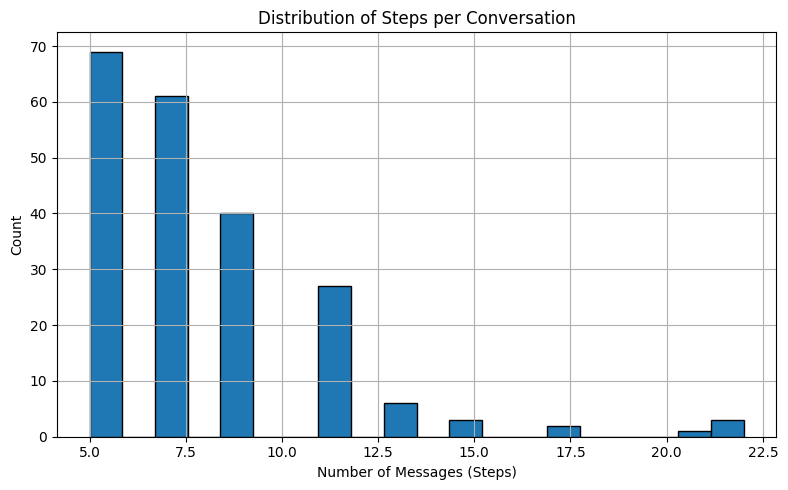

In [30]:
import matplotlib.pyplot as plt

# Convert to Pandas
df = qwen.select(["conversation_count"]).to_pandas()

# Plot histogram of steps (number of messages per conversation)
plt.figure(figsize=(8, 5))
plt.hist(df["conversation_count"], bins=20, edgecolor="black")
plt.title("Distribution of Steps per Conversation")
plt.xlabel("Number of Messages (Steps)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

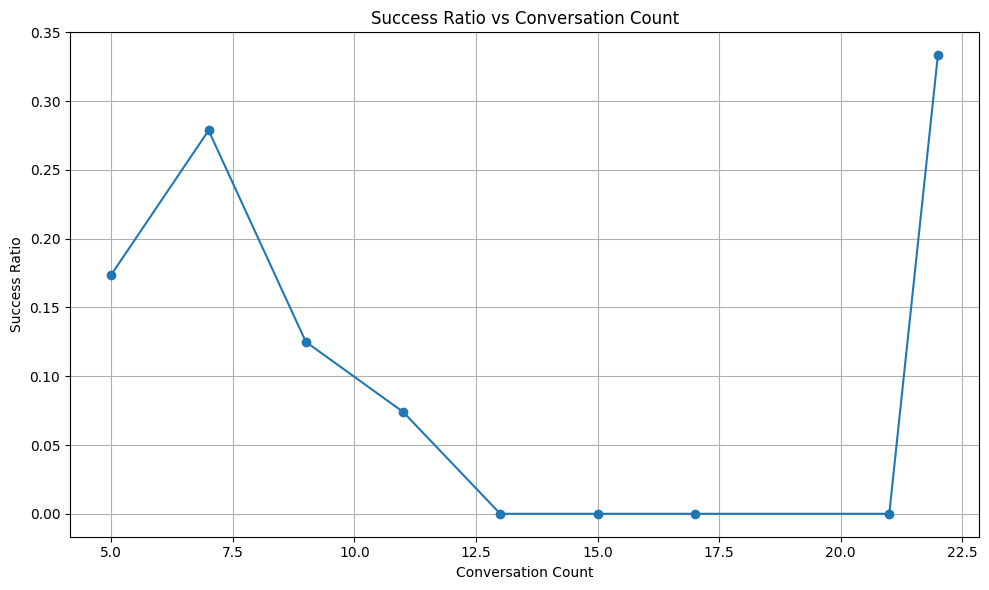

In [ ]:
import polars as pl
import matplotlib.pyplot as plt

# Group by "conversation_count" and compute success stats
success_stats = (
    qwen
    .group_by("conversation_count")
    .agg([
        pl.col("success").sum().alias("success_count"),
        pl.col("success").len().alias("total_count")
    ])
    .with_columns([
        (pl.col("success_count") / pl.col("total_count")).alias("success_ratio")
    ])
    .sort("conversation_count")
)

# Extract values for plotting
x = success_stats["conversation_count"].to_list()
y = success_stats["success_ratio"].to_list()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o')
plt.title("Success Ratio vs Conversation Count")
plt.xlabel("Conversation Count")
plt.ylabel("Success Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
qwen.to_pandas().describe()
conversation_count

,reward,success,conversation_count,total_word_count,char_lengths
count,212.000000,212.000000,212.000000,212.000000,212.000000
mean,0.402516,0.174528,7.891509,2107.943396,12483.179245
std,0.358264,0.380462,3.213202,912.416196,4165.682629
min,0.000000,0.000000,5.000000,1557.000000,9334.000000
25%,0.000000,0.000000,5.000000,1716.750000,10495.000000
50%,0.500000,0.000000,7.000000,1796.500000,11175.500000
75%,0.500000,0.000000,9.000000,2087.250000,12683.750000
max,1.000000,1.000000,22.000000,7500.000000,36380.000000


In [ ]:
import polars as pl
import matplotlib.pyplot as plt

# Assign each row to a bucket
qwen = qwen.with_columns([
    pl.when(pl.col("conversation_count") <= 5).then("0_5")
    .when(pl.col("conversation_count") <= 10).then("6_10")
    .when(pl.col("conversation_count") <= 15).then("11_15")
    .when(pl.col("conversation_count") <= 20).then("16_20")
    .otherwise("21_25")
    .alias("conversation_bucket")
])

### large step selections

## split

In [48]:
df_gpt = pd.read_json("./_sft/qwen1b_sft.jsonl", lines=True)

# Replace 'gpt' with 'assistant' inside each conversation
for convo in df_gpt["conversation"]:
    for msg in convo:
        if msg.get("from") == "gpt":
            msg["role"] = "assistant"
           
        elif msg.get("from") == "human":
            msg["role"] = "user"
        if "loss" in msg:
            msg.pop("loss")
        msg.pop("from")
        msg["content"] = msg["value"]
        msg.pop("value")

In [11]:
df_new["step"].value_counts()

KeyError: 'step'

In [7]:
df_new["conversation"][2]

[{'from': 'human',
  'loss': None,
  'value': '\nYou are an autonomous intelligent agent for managing Gmail calendars. There are two types of users who interact with you:the owner (who controls the calendar) and others (who do not). When the user is the owner, use list_events to find events. For others, use check_availability or find_free_time to find available time slots in the owner\'s calendar. \nCurrent User:owners\nOwner Email:myagentcalander0@gmail.com\nOwner Name:Agent Zero\nToday_Date:2025-08-14 21:02:09\nOwner preference:\n\nPrivacy:fields in private_field (creator, visibility, attendees, hangoutLink, summary, description, location) are omitted from outputs for owner.\nWhen others schedule with the owner, please follow owner\'s preferences as closely as possible\nWe detail name, description, input(parameters) and output(returns) of each action as follows:\n\nActions:\nName:list_calendars\nDescription:List all available calendars in the user\'s Gmail account.\nParameters:\n- No

In [50]:
df_gpt[["conversation","reward",	"success",	"item_id"]].to_json(
    "./_pre_train/qwen7b_eval_new.jsonl",
    orient="records",
    lines=True,
    force_ascii=False  # Optional: keeps Unicode characters readable
)

In [51]:
import json
import random
from sklearn.model_selection import KFold

# Load data
with open("./_pre_train/qwen7b_eval_new.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

# Shuffle and split into 90% train+val, 10% test
random.seed(42)
random.shuffle(data)
n_total = len(data)
n_test = int(0.06 * n_total)

test_data = data[:n_test]
trainval_data = data[n_test:]

# Save test set
with open("./_sft/test.jsonl", "w") as f:
    for item in test_data:
        f.write(json.dumps(item) + "\n")

# 4-fold CV on 90% trainval split
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for fold_id, (train_idx, val_idx) in enumerate(kf.split(trainval_data)):
    train_fold = [trainval_data[i] for i in train_idx]
    val_fold = [trainval_data[i] for i in val_idx]

    with open(f"./_sft/train_fold_{fold_id}.jsonl", "w") as f:
        for item in train_fold:
            f.write(json.dumps(item) + "\n")

    with open(f"./_sft/val_fold_{fold_id}.jsonl", "w") as f:
        for item in val_fold:
            f.write(json.dumps(item) + "\n")

print("✅ Finished 3-fold split with 90/10 train-test split.")

✅ Finished 3-fold split with 90/10 train-test split.


In [ ]:
from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    GemmaTokenizerFast,
    Gemma2Config,
    PreTrainedTokenizerBase,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)


encode = CustomTokenizer(tokenizer, max_length=config.max_length)
trainer = Trainer(
    args=training_args,
    model=model,
    tokenizer=tokenizer,
    #train_dataset=ds.select(train_idx),
    #eval_dataset=ds.select(eval_idx),
    #compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
)

In [ ]:
student_logits = student_model(input_ids).logits
student_soft = torch.nn.functional.log_softmax(student_logits / temperature, dim=-1)

In [ ]:
student_logits = student_model(input_ids).logits
student_soft = torch.nn.functional.log_softmax(student_logits / temperature, dim=-1)

kl_loss = torch.nn.functional.kl_div(student_soft, teacher_soft_targets, reduction="batchmean") * (temperature ** 2)

In [10]:
logits shape: [batch_size, seq_length, vocab_size] => This vector contains one score per token in the vocabulary — e.g., 50,000 floats.
	•	logits shape: [batch_size, seq_length, vocab_size]
	•	If batch = 1, sequence = 5 tokens, vocab = 50,000
→ logits will be of shape [1, 5, 50000]

Each position has 50,000 scores — one per vocab token.
probs = torch.softmax(logits[0, -1], dim=-1)
	•	.argmax() for greedy prediction
	•	torch.multinomial() for sampling

top_k = torch.topk(probs, k=5)
Top tokens: ["dog", "mat", "floor", "bed", "."]
Probabilities: [0.45, 0.21, 0.12, 0.08, 0.07]



SyntaxError: invalid character '—' (U+2014) (3501480541.py, line 1)